In [2]:
import pandas as pd
import math
import numpy as np
import time

import seaborn as sns

import numpy as np
from sklearn.manifold import TSNE
from sklearn.manifold import MDS

from sklearn.manifold import spectral_embedding

In [3]:
name = 'NBA'
output_folder  = '{}/{}'.format('data', name)
simFile = '{}/similarity'.format(output_folder)

In [4]:
insight_df = pd.read_csv('./rawData/{}/insight.csv'.format(name))
subspace_df = pd.read_csv('./rawData/{}/subspace.csv'.format(name))

# insight_columns: insights columns
# subspace_columns: subspaces

insight_columns = insight_df.columns[:10]
subspace_columns = subspace_df.columns

result_df = insight_df[insight_columns].merge(subspace_df, left_on='sid', right_on='sid')
result_df['index'] = result_df.index

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
result_df.columns

Index(['breakdown', 'breakdown_value', 'measure', 'sig', 'impact', 'insight',
       'insight_type', 'score', 'iid', 'sid', 'name', 'year', 'team_name',
       'age', 'lg_name', 'pos_name', 'index'],
      dtype='object')

In [6]:
# A: features used  to calculate similarity
# M: the size of data

A = list(subspace_columns)[:-1] + ['breakdown', 'measure', 'insight'] 
N = result_df.shape[0]

In [7]:
subspace_range = [0, len(subspace_columns)]

In [8]:
subspace_len = len(subspace_columns)
print(A)
print(subspace_len, len(A))

['name', 'year', 'team_name', 'age', 'lg_name', 'pos_name', 'breakdown', 'measure', 'insight']
7 9


In [61]:
# function f(k, x); funciton p(k, x) p2(k, x)

kx_map = {}
for (k, a) in enumerate(A):
    if k not in kx_map:
        kx_map[k] = {}
    x_count = result_df[[a, 'index']].groupby(a).count().reset_index()
    for obj in x_count.to_dict('records'):
        kx_map[k][obj[a]] = obj['index']
        
        
def f(k, x):
    if k not in kx_map:
        return False
    if x not in kx_map[k]:
        return 0
    return kx_map[k][x]

insight_records= result_df.to_dict('records')

def p(k, x):
    fkx = f(k, x)
    if fkx == False:
        return False
    return fkx / N

def p2(k, x):
    fkx = f(k,x)
    if fkx == False:
        return False
    return fkx * (fkx-1) / (N * (N-1)) 

def linw(src, dst):
    s = 0
    for (k, a) in enumerate(A):
        Xk, Yk =  src[a], dst[a]
        s += (np.log2(p(k, Xk)) + np.log2(p(k, Yk))) 
    return 1/s 

def linS(k, src, dst):
    key = A[k]
    Xk, Yk = src[key], dst[key]
    if Xk == Yk:
        return 2 * np.log2(p(k, Xk))
    return 2*np.log2(p(k, Xk) + p(k, Yk))

# def lin(src, dst):
#     w = linw(src, dst)
#     sim = 0
#     print(w)
#     for (k, a) in enumerate(A):
# #         if k < subspace_len:
# #             w *= 1 / len(subspace_columns)
#         print('---', A[k], linS(k, src, dst), w*linS(k, src, dst), src[a], dst[a])
#         sim += w*(linS(k, src, dst))
#     print("sum", sim)
#     print('\n')
#     return sim

def lin(src, dst):
    w = linw(src, dst)
    sim = 0
#     print(w)
    obj = {}
    obj['w'] = w
    for (k, a) in enumerate(A):
#         if k < subspace_len:
#             w = w*( 1 / len(subspace_columns))
             
#         print('---', A[k], linS(k, src, dst), w*linS(k, src, dst), src[a], dst[a])
        obj["{}_{}".format(A[k], 'all')] = w*(linS(k, src, dst))
        obj["{}_{}".format(A[k], 's')] = linS(k, src, dst)
        sim += w*(linS(k, src, dst))
#     print("sum", sim)
#     print('\n')
    return sim, obj



In [85]:
simMatrix = np.zeros((N, N))
start_time = time.time()
objs = []
for i in range(0, len(insight_records)):
    src = insight_records[i]
    for j in range(i, len(insight_records)):
        if i == j:
            simMatrix[i][j] = 1
        else:
            dst = insight_records[j]
            simMatrix[i][j], obj = lin(src, dst)
            simMatrix[j][i] = simMatrix[i][j]
            obj['srcIndex'] = i
            obj['dstIndex'] = j
            obj['score'] = simMatrix[i][j]
            objs.append(obj)
#             print(simMatrix)
#         if j > 4:
#             break
#     break
end_time = time.time()
print('use time ', end_time - start_time)

use time  23.51019310951233


In [86]:
score_df = pd.DataFrame(data = objs)

In [87]:
score_df.shape

(210925, 22)

In [88]:
score_df

,w,name_all,name_s,year_all,year_s,team_name_all,team_name_s,age_all,age_s,lg_name_all,...,pos_name_s,breakdown_all,breakdown_s,measure_all,measure_s,insight_all,insight_s,srcIndex,dstIndex,score
0,-0.034220,-0.0,0.0,-0.0,0.0,0.531045,-15.518667,0.038527,-1.125872,0.001377,...,-0.911105,0.066932,-1.955947,0.076343,-2.230954,0.184817,-5.400879,0,1,0.930218
1,-0.031786,-0.0,0.0,-0.0,0.0,0.493283,-15.518667,0.035787,-1.125872,0.001279,...,-0.911105,0.044529,-1.400879,0.070914,-2.230954,0.108102,-3.400879,0,2,0.782856
2,-0.034940,-0.0,0.0,-0.0,0.0,0.025647,-0.734032,0.038426,-1.099760,0.001406,...,-0.911105,0.068341,-1.955947,0.077949,-2.230954,0.188706,-5.400879,0,3,0.432309
3,-0.034622,-0.0,0.0,-0.0,0.0,0.025413,-0.734032,0.038076,-1.099760,0.001393,...,-0.911105,0.067718,-1.955947,0.016688,-0.482016,0.186988,-5.400879,0,4,0.367820
4,-0.035105,-0.0,0.0,-0.0,0.0,0.445434,-12.688592,0.039524,-1.125872,0.001412,...,-0.911105,0.068664,-1.955947,0.078318,-2.230954,0.189598,-5.400879,0,5,0.854934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210920,-0.026441,-0.0,0.0,-0.0,0.0,0.019560,-0.739763,0.029769,-1.125872,0.041964,...,-0.850865,0.037041,-1.400879,0.072898,-2.757023,0.089922,-3.400879,646,648,0.313652
210921,-0.031005,-0.0,0.0,-0.0,0.0,0.022936,-0.739763,0.034907,-1.125872,0.049207,...,-0.911105,0.043434,-1.400879,0.085480,-2.757023,0.105443,-3.400879,646,649,0.369655
210922,-0.028522,-0.0,0.0,-0.0,0.0,0.020773,-0.728313,0.032113,-1.125872,0.072303,...,-0.850865,0.055788,-1.955947,0.078637,-2.757023,0.154046,-5.400879,647,648,0.437930
210923,-0.033906,-0.0,0.0,-0.0,0.0,0.024694,-0.728313,0.038174,-1.125872,0.085951,...,-0.911105,0.066318,-1.955947,0.093480,-2.757023,0.183123,-5.400879,647,649,0.522631


In [89]:
objs[0]

{'w': -0.03421974262881832,
 'name_all': -0.0,
 'name_s': 0.0,
 'year_all': -0.0,
 'year_s': 0.0,
 'team_name_all': 0.5310447843307865,
 'team_name_s': -15.518666814389322,
 'age_all': 0.038527063377023676,
 'age_s': -1.1258723887823143,
 'lg_name_all': 0.0013766849729432552,
 'lg_name_s': -0.04023072259415164,
 'pos_name_all': 0.031177789490909318,
 'pos_name_s': -0.9111053180351155,
 'breakdown_all': 0.06693201619028451,
 'breakdown_s': -1.9559473873400024,
 'measure_all': 0.07634268657684125,
 'measure_s': -2.2309544348398718,
 'insight_all': 0.18481670427885372,
 'insight_s': -5.400879436282184,
 'srcIndex': 0,
 'dstIndex': 1,
 'score': 0.9302177292176423}

In [90]:
simMatrix

array([[1.        , 0.93021773, 0.78285565, ..., 0.86321435, 0.37159338,
        0.44340357],
       [0.93021773, 1.        , 0.84533105, ..., 0.79082308, 0.34940738,
        0.41815753],
       [0.78285565, 0.84533105, 1.        , ..., 0.65270568, 0.25915825,
        0.30701398],
       ...,
       [0.86321435, 0.79082308, 0.65270568, ..., 1.        , 0.43793012,
        0.52263139],
       [0.37159338, 0.34940738, 0.25915825, ..., 0.43793012, 1.        ,
        0.8399472 ],
       [0.44340357, 0.41815753, 0.30701398, ..., 0.52263139, 0.8399472 ,
        1.        ]])

In [91]:
# simMatrix = np.zeros((N, N))
# start_time = time.time()
# results_dict = []
# for i in range(0, len(insight_records)):
#     src = insight_records[i]
#     for j in range(i, len(insight_records)):
#         if i == j:
#             simMatrix[i][j] = 1
#         else:
#             dst = insight_records[j]
#             simMatrix[i][j] = float(lin(src, dst))
#             simMatrix[j][i] = simMatrix[i][j]
#             print(simMatrix)
#         if j > 4:
#             break
#     break
# end_time = time.time()
# print('use time ', end_time - start_time)

In [92]:
# def generate_projection(sim_matrix, perplexity = 12):
    
#     st = time.time()
#     X_embedded = TSNE(n_components=2, 
#                    init='random', perplexity=perplexity).fit_transform(sim_matrix)

# #     X_embedded = MDS(n_components=2).fit_transform(sim_matrix)
    
# #     X_embedded = spectral_embedding(sim_matrix, n_components=2)
#     print(time.time() - st)
#     return X_embedded

def visualize_matrix(projection):
    df = pd.DataFrame(columns=['x', 'y'], data=projection)
    sns.scatterplot(data=df, x="x", y="y")

def calc_projection(sim, index_list, perplexity = 50):
    matrix = sim if type(sim) != str else np.load(simFile.format(output_folder, 'npz'))
    sub_matrix = matrix[index_list][:, index_list]
    X_embedded = generate_projection(sub_matrix, perplexity)
    return X_embedded

In [93]:
def generate_projection(sim_matrix, perplexity = 12):
    
    st = time.time()
#     X_embedded = TSNE(n_components=2, 
#                    init='random', perplexity=perplexity).fit_transform(sim_matrix)

#     X_embedded = MDS(n_components=2).fit_transform(sim_matrix)
    
    X_embedded = spectral_embedding(sim_matrix, n_components=2)
    print(time.time() - st)
    return X_embedded


0.047895193099975586


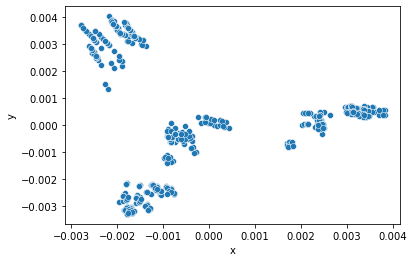

In [94]:
projection = calc_projection(simMatrix, [i for i in range(0, 650)], perplexity=45)
visualize_matrix(projection)

In [95]:
score_df

,w,name_all,name_s,year_all,year_s,team_name_all,team_name_s,age_all,age_s,lg_name_all,...,pos_name_s,breakdown_all,breakdown_s,measure_all,measure_s,insight_all,insight_s,srcIndex,dstIndex,score
0,-0.034220,-0.0,0.0,-0.0,0.0,0.531045,-15.518667,0.038527,-1.125872,0.001377,...,-0.911105,0.066932,-1.955947,0.076343,-2.230954,0.184817,-5.400879,0,1,0.930218
1,-0.031786,-0.0,0.0,-0.0,0.0,0.493283,-15.518667,0.035787,-1.125872,0.001279,...,-0.911105,0.044529,-1.400879,0.070914,-2.230954,0.108102,-3.400879,0,2,0.782856
2,-0.034940,-0.0,0.0,-0.0,0.0,0.025647,-0.734032,0.038426,-1.099760,0.001406,...,-0.911105,0.068341,-1.955947,0.077949,-2.230954,0.188706,-5.400879,0,3,0.432309
3,-0.034622,-0.0,0.0,-0.0,0.0,0.025413,-0.734032,0.038076,-1.099760,0.001393,...,-0.911105,0.067718,-1.955947,0.016688,-0.482016,0.186988,-5.400879,0,4,0.367820
4,-0.035105,-0.0,0.0,-0.0,0.0,0.445434,-12.688592,0.039524,-1.125872,0.001412,...,-0.911105,0.068664,-1.955947,0.078318,-2.230954,0.189598,-5.400879,0,5,0.854934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210920,-0.026441,-0.0,0.0,-0.0,0.0,0.019560,-0.739763,0.029769,-1.125872,0.041964,...,-0.850865,0.037041,-1.400879,0.072898,-2.757023,0.089922,-3.400879,646,648,0.313652
210921,-0.031005,-0.0,0.0,-0.0,0.0,0.022936,-0.739763,0.034907,-1.125872,0.049207,...,-0.911105,0.043434,-1.400879,0.085480,-2.757023,0.105443,-3.400879,646,649,0.369655
210922,-0.028522,-0.0,0.0,-0.0,0.0,0.020773,-0.728313,0.032113,-1.125872,0.072303,...,-0.850865,0.055788,-1.955947,0.078637,-2.757023,0.154046,-5.400879,647,648,0.437930
210923,-0.033906,-0.0,0.0,-0.0,0.0,0.024694,-0.728313,0.038174,-1.125872,0.085951,...,-0.911105,0.066318,-1.955947,0.093480,-2.757023,0.183123,-5.400879,647,649,0.522631


In [102]:
score_df.sort_values(['score'], ascending=False)

,w,name_all,name_s,year_all,year_s,team_name_all,team_name_s,age_all,age_s,lg_name_all,...,pos_name_s,breakdown_all,breakdown_s,measure_all,measure_s,insight_all,insight_s,srcIndex,dstIndex,score
133511,-0.047067,-0.0,0.0,-0.0,0.0,0.035360,-0.751258,0.052992,-1.125872,0.120324,...,-0.911105,0.295097,-6.269685,0.105005,-2.230954,0.348339,-7.400879,256,264,1.000000
135081,-0.047067,-0.0,0.0,-0.0,0.0,0.035360,-0.751258,0.052992,-1.125872,0.120324,...,-0.911105,0.295097,-6.269685,0.105005,-2.230954,0.348339,-7.400879,260,272,1.000000
135459,-0.047067,-0.0,0.0,-0.0,0.0,0.035360,-0.751258,0.052992,-1.125872,0.120324,...,-0.911105,0.295097,-6.269685,0.105005,-2.230954,0.348339,-7.400879,261,262,1.000000
135460,-0.047067,-0.0,0.0,-0.0,0.0,0.035360,-0.751258,0.052992,-1.125872,0.120324,...,-0.911105,0.295097,-6.269685,0.105005,-2.230954,0.348339,-7.400879,261,263,1.000000
135461,-0.047067,-0.0,0.0,-0.0,0.0,0.035360,-0.751258,0.052992,-1.125872,0.120324,...,-0.911105,0.295097,-6.269685,0.105005,-2.230954,0.348339,-7.400879,261,264,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20873,-0.030576,-0.0,0.0,-0.0,0.0,0.022794,-0.745505,0.033626,-1.099760,0.001230,...,-0.911105,0.042833,-1.400879,0.014738,-0.482016,0.103985,-3.400879,32,634,0.247064
20874,-0.030576,-0.0,0.0,-0.0,0.0,0.022794,-0.745505,0.033626,-1.099760,0.001230,...,-0.911105,0.042833,-1.400879,0.014738,-0.482016,0.103985,-3.400879,32,635,0.247064
20880,-0.030576,-0.0,0.0,-0.0,0.0,0.022794,-0.745505,0.033626,-1.099760,0.001230,...,-0.911105,0.042833,-1.400879,0.014738,-0.482016,0.103985,-3.400879,32,641,0.247064
20876,-0.030576,-0.0,0.0,-0.0,0.0,0.022794,-0.745505,0.033626,-1.099760,0.001230,...,-0.911105,0.042833,-1.400879,0.014738,-0.482016,0.103985,-3.400879,32,637,0.247064


In [ ]:
# np.savez("{}/{}.npz".format(output_folder, 'projection'), projection = projection)

In [ ]:
type('123') == str

In [ ]:
emb = calc_projection(simMatrix, [i for i in range(0, 649)], perplexity=12)
visualize_matrix(emb)

In [ ]:
test_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
test_index = [i for i in range(0, 374)]
sub_similarity = simMatrix[test_index][:, test_index]

In [ ]:
sub_similarity

In [ ]:
X_embedded = generate_projection(sub_similarity, 99)
visualize_matrix(X_embedded)

In [ ]:
simMatrix[[1,2,3]][:, [1,2,3]].shape

In [ ]:
simMatrix[[1,5,7]][:, [1,5,7]]

In [ ]:
simMatrix[[1]]

## Save similarity matrix

In [ ]:

start_time = time.time()
X_embedded = TSNE(n_components=2, 
                   init='random', perplexity=12).fit_transform(simMatrix)
print("Use time: ", time.time() - start_time)

projection = pd.DataFrame(columns=['x', 'y'], data = X_embedded)
sns.scatterplot(data=projection, x="x", y="y")

In [ ]:
result_df[['x', 'y']] = projection.values
result_df.to_csv('projection.csv', index = False)

In [ ]:
def generate_projection():
    pass

## process subspace

In [ ]:
sub_df = result_df[result_df['team_name'] == 'Los Angeles Lakers']

sub_N = sub_df.shape[0]
sub_simMatrix = np.zeros((sub_N, sub_N))
start_time = time.time()
sub_insight_records = sub_df.to_dict('records')
for i in range(0, len(sub_insight_records)):
    src = sub_insight_records[i]
    for j in range(i+1, len(sub_insight_records)):
        dst = sub_insight_records[j]
        sub_simMatrix[i][j] = float(lin(src, dst))
        sub_simMatrix[j][i] = sub_simMatrix[i][j]

end_time = time.time()
print('use time ', end_time - start_time)

In [ ]:
tart_time = time.time()
sub_embedded = TSNE(n_components=2, 
                   init='random', perplexity=5).fit_transform(sub_simMatrix)
print("Use time: ", time.time() - start_time)

sub_projection = pd.DataFrame(columns=['x', 'y'], data = sub_embedded)
sns.scatterplot(data=sub_projection, x="x", y="y")

In [ ]:
sub_df[['x', 'y']] = sub_projection.values
sub_df.to_csv('subspace.csv', index = False)

## breakdown subspace

In [ ]:
result_df['breakdown'].unique()

In [ ]:
result_df[['breakdown','age']].groupby('breakdown').count()

In [ ]:
result_df[['lg_name','age']].groupby('lg_name').count()

In [ ]:
breakdown_df = result_df[result_df['breakdown'] == 'lg_name']

breakdown_N = breakdown_df.shape[0]
breakdown_simMatrix = np.zeros((breakdown_N, breakdown_N))
start_time = time.time()
breakdown_insight_records = breakdown_df.to_dict('records')
for i in range(0, len(breakdown_insight_records)):
    src = breakdown_insight_records[i]
    for j in range(i+1, len(breakdown_insight_records)):
        dst = breakdown_insight_records[j]
        breakdown_simMatrix[i][j] = float(lin(src, dst))
        breakdown_simMatrix[j][i] = breakdown_simMatrix[i][j]
        

end_time = time.time()
print('use time ', end_time - start_time)

In [ ]:
tart_time = time.time()
breakdown_embedded = TSNE(n_components=2, 
                   init='random', perplexity=50).fit_transform(breakdown_simMatrix)
print("Use time: ", time.time() - start_time)

breakdown_projection = pd.DataFrame(columns=['x', 'y'], data = breakdown_embedded)
sns.scatterplot(data=breakdown_projection, x="x", y="y")

In [ ]:
breakdown_df[['x', 'y']] = breakdown_projection.values
breakdown_df.to_csv('breakdown.csv', index = False)

## breakdown  and  subspace

In [ ]:
bs_df = result_df[(result_df['breakdown'] == 'lg_name')&(result_df['team_name'] == 'Los Angeles Lakers')]

bs_N = bs_df.shape[0]
bs_simMatrix = np.zeros((bs_N, bs_N))
start_time = time.time()
bs_insight_records = bs_df.to_dict('records')
for i in range(0, len(bs_insight_records)):
    src = bs_insight_records[i]
    for j in range(i+1, len(bs_insight_records)):
        dst = bs_insight_records[j]
        bs_simMatrix[i][j] = float(lin(src, dst))
        bs_simMatrix[j][i] = bs_simMatrix[i][j]
        

# end_time = time.time()
# print('use time ', end_time - start_time)

In [ ]:
tart_time = time.time()
bs_embedded = TSNE(n_components=2, 
                   init='random', perplexity=50).fit_transform(bs_simMatrix)
print("Use time: ", time.time() - start_time)

bs_projection = pd.DataFrame(columns=['x', 'y'], data = bs_embedded)
sns.scatterplot(data=bs_projection, x="x", y="y")

In [ ]:
bs_df[['x', 'y']] = bs_projection.values
bs_df.to_csv('bs.csv', index = False)

In [ ]:
result_df['year'].shape